In [1]:
#!/usr/bin/env python3
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline as spline
from sympy import I
import vmec
from mpi4py import MPI
from simsopt.mhd import Vmec
from neat.fields import StellnaQS, Vmec as Vmec_NEAT
from neat.tracing import ChargedParticle, ParticleOrbit

Trace the orbit of a single particle in a
quasisymmetric stellarator using Near Axis and VMEC   

In [2]:
# step_i=0.3
s_initial = 0.1 # psi/psi_a for vmec
lambda_i=0.2 # = mu * B0 / energy
theta_initial=0.3
phi_initial=0.3

B0 = 5.3267         # Tesla, magnetic field on-axis (ARIES-CS)
energy = 3.52e6     # electron-volt
charge = 2          # times charge of proton
mass = 4            # times mass of proton     
vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
nsamples = 1000     # resolution in time
tfinal = 1e-5       # seconds
constant_b20 =False # use a constant B20 (mean value) or the real function

Rmajor_ARIES = 7.7495*1.5
Rminor_ARIES = 1.7044
r_avg=Rminor_ARIES

filename_vmec = f"input.nearaxis_{np.round(Rmajor_ARIES/r_avg,2)}"
wout_filename_vmec = f"wout_nearaxis_{np.round(Rmajor_ARIES/r_avg,2)}_QA_000_000000.nc"

g_field_basis = StellnaQS.from_paper('precise QA', B0=B0, nphi=401)
g_field = StellnaQS(rc=g_field_basis.rc*Rmajor_ARIES, zs=g_field_basis.zs*Rmajor_ARIES, \
                    etabar=g_field_basis.etabar/Rmajor_ARIES, B2c=g_field_basis.B2c*(B0/Rmajor_ARIES/Rmajor_ARIES),\
                        B0=B0, nfp=g_field_basis.nfp, order='r3', nphi=401)

nu_array = g_field.varphi - g_field.phi
nu_spline_of_varphi = spline(
    np.append(g_field.varphi, 2 * np.pi / g_field.nfp),
    np.append(nu_array, nu_array[0]),
    bc_type="periodic",
)

# g_field.to_vmec(filename=filename_vmec,r=r_avg, params={"ntor":12, "mpol":12, "niter_array":[10000,10000,20000],'ftol_array':[1e-14,1e-16,1e-17],'ns_array':[16,49,101]}, ntheta=48, ntorMax=48) #standard ntheta=20, ntorMax=14
# vmec=Vmec(filename=filename_vmec, verbose=True)
# vmec.run()

g_particle_vmec = ChargedParticle(
    r_initial = s_initial,
    theta_initial = theta_initial,     
    phi_initial = phi_initial,    
    energy = energy,
    Lambda = lambda_i,
    charge = charge,
    mass = mass,
    vpp_sign = vpp_sign,
)

In [3]:
g_fields_vmec=[]
g_orbits_vmec=[]
g_orbits_vmec_all=[]
total_times=[]
total_times_all=[]
En_losses=[]
En_losses_all=[]

algorithms=[1,2,3,4,5,6,7,8,9]
for i in algorithms:
    g_fields_vmec.append(Vmec_NEAT(wout_filename=wout_filename_vmec,integrator=i))

In [4]:
for i in np.arange(0,9,1):
    print("Starting particle tracer with: " + str(algorithms[i]))
    
    for j in np.arange(0,5,1):
        start_time = time.time()
        g_orbits_vmec.append(ParticleOrbit(g_particle_vmec, g_fields_vmec[i], nsamples = 10**(j+1),
            tfinal = tfinal, constant_b20 = constant_b20))
        total_times.append( time.time() - start_time )
        print(f"Finished in {total_times[-1]}s")
        En_losses.append((np.max(g_orbits_vmec[j].total_energy - g_orbits_vmec[j].total_energy[0])) / g_orbits_vmec[j].total_energy[0])
    
    g_orbits_vmec_all.append(g_orbits_vmec)
    total_times_all.append(total_times)
    En_losses_all.append(En_losses)
    g_orbits_vmec=[]
    total_times=[]
    En_losses=[]


Starting particle tracer with: 1
Finished in 0.018886327743530273s
Finished in 0.06618571281433105s
Finished in 0.37790632247924805s
Finished in 2.968461275100708s
Finished in 29.51607084274292s
Starting particle tracer with: 2
Finished in 0.01529836654663086s
Finished in 0.05578804016113281s
Finished in 0.45235300064086914s
Finished in 4.399132251739502s
Finished in 43.3721969127655s
Starting particle tracer with: 3
Finished in 0.020627498626708984s
Finished in 0.10798120498657227s
Finished in 0.953376054763794s
Finished in 9.277324438095093s
Finished in 91.38527870178223s
Starting particle tracer with: 4
Finished in 0.014937400817871094s
Finished in 0.05547690391540527s
Finished in 0.4495582580566406s
Finished in 4.463826894760132s
Finished in 43.87679409980774s
Starting particle tracer with: 5
Finished in 0.044832468032836914s
Finished in 0.11023807525634766s
Finished in 0.5297231674194336s
Finished in 5.037444591522217s
Finished in 50.04443049430847s
Starting particle tracer with: 

In [5]:
# plt.figure(figsize=(10, 6))

# for i in np.arange(1,8,1):  
#     if not os.path.exists('Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg)):
#         os.mkdir('Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg))

#     if not os.path.exists('Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(s_initial)):
#         os.mkdir('Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg)+ '/' + str(s_initial))
#     plt.rcParams["figure.facecolor"] = "w"
#     plt.plot(g_orbits_vmec[i-1].time*1e6, g_orbits_vmec[i-1].r_pos,label='vmec s_i='+str(np.round(0.1 + step_i*i,2)))
#     plt.plot(g_orbit.time*1e6, norm_r_pos,label='qsc s_i='+str(np.round(0.1 + step_i*i,2)))
#     plt.legend(fontsize='small', loc=(0.6,0.15), ncol=2)
#     plt.xlabel(r't ($\mu$s)')
#     plt.savefig('Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/r_pos',transparent=False)
#     plt.show()

#     # print('NEAT')
#     # g_orbit.plot_orbit_contourB(savefig='Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/B_neat')
#     # print('VMEC')
#     # g_orbits_vmec[i-1].plot_orbit_contourB(savefig='Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/B_vmec')
#     # print('NEAT-VMEC')
#     # g_orbit.plot_diff_boozer(g_orbits_vmec[i-1],r_minor=r_avg,savefig='Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/diff_booz_neat_vmec')
#     # print('NEAT-VMEC')
#     # g_orbit.plot_diff_cyl(g_orbits_vmec[i-1],savefig='Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/diff_cyl_neat_vmec')
#     print('NEAT')
#     g_orbit.plot(savefig='Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/param_neat')
#     print('VMEC')
#     g_orbits_vmec[i-1].plot(savefig='Integrator=' + str(i) +'_A=' + str(Rmajor_ARIES/r_avg) + '/' + str(s_initial)+'/param_vmec')


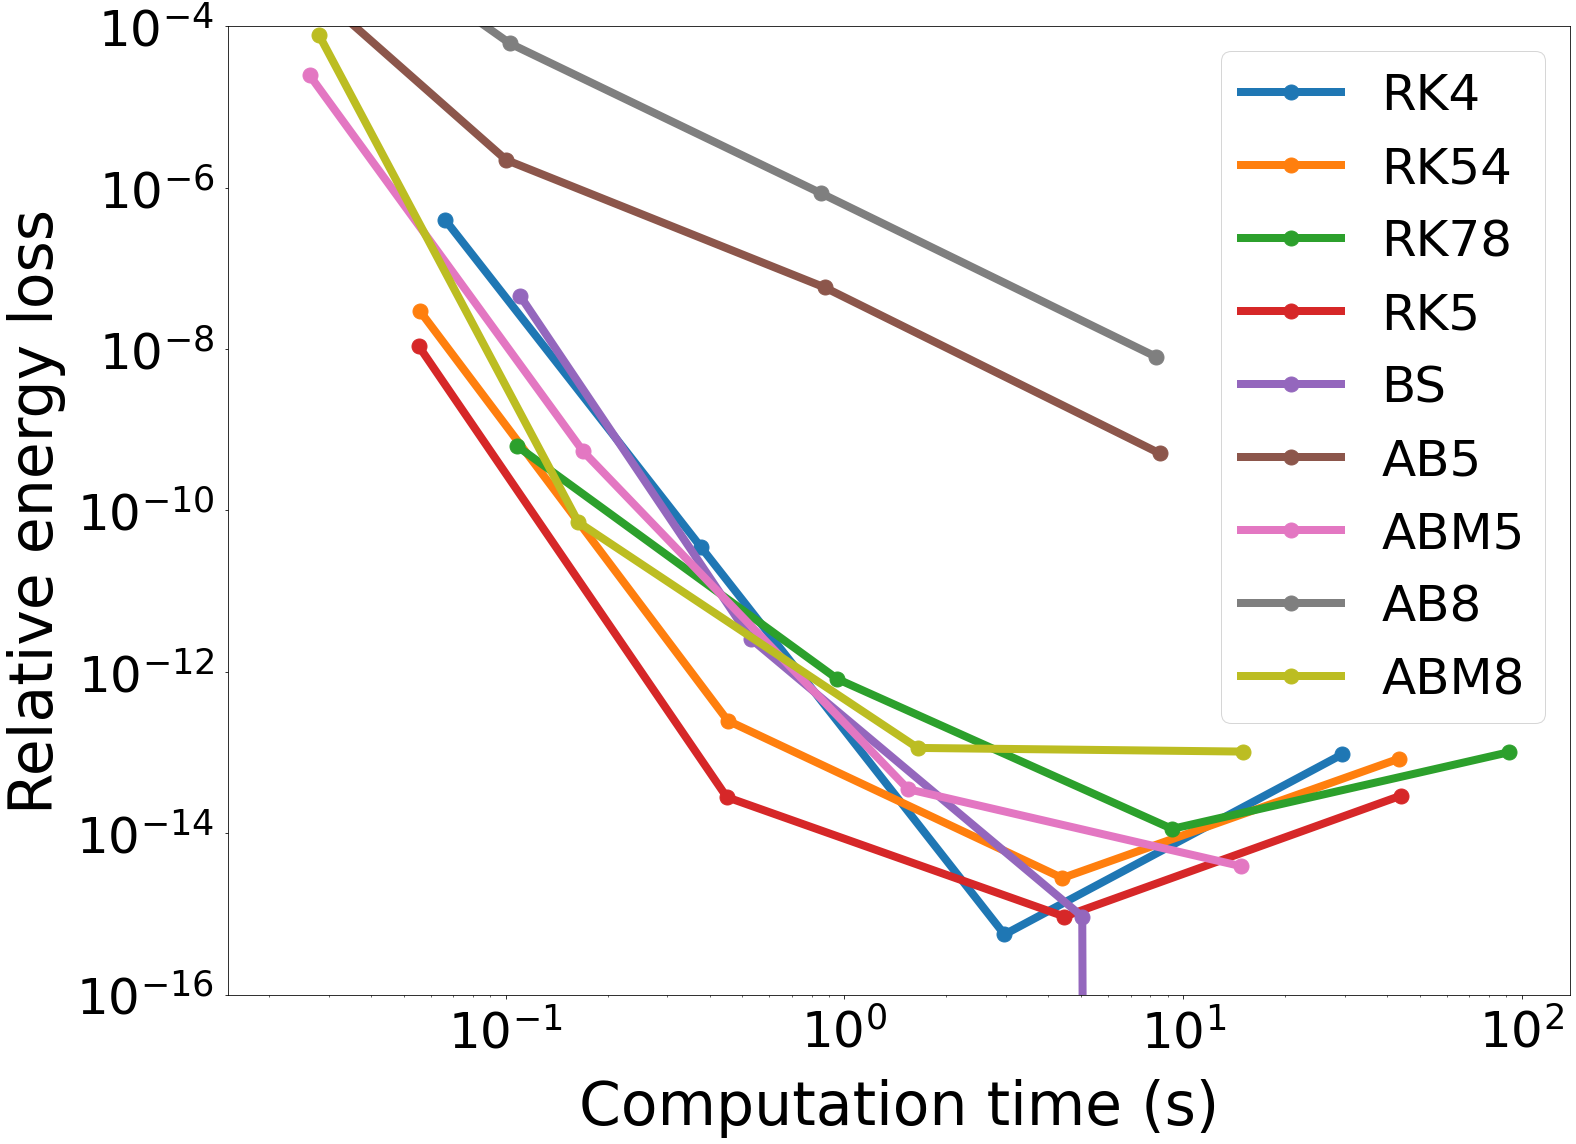

In [6]:
integrators=['RK4','RK54','RK78','RK5','BS','AB5','ABM5','AB8','ABM8']
# integrators = ['RK54', 'RK54-adapt','RK78', 'RK78-adapt' ,'RK5','RK5-adapt' ,'BS']
plt.figure(figsize=(22,16))
plt.rc('lines',linewidth=8)
for i in np.arange(0,9,1):
    plt.plot(total_times_all[i][1:],np.abs(En_losses_all[i][1:]),linestyle='-',marker='.',markersize=30,label=integrators[i])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-16,1e-4)
plt.tick_params(axis='x', labelsize=50,pad=10)
plt.tick_params(axis='y', labelsize=50,pad=10)
plt.xlabel('Computation time (s)', fontsize=60,labelpad=20)
plt.ylabel('Relative energy loss', fontsize=60,labelpad=10)
plt.legend(loc='best',fontsize=50)
plt.tight_layout()
plt.savefig('integrators.pdf')
plt.show()